# M2: Primate Finger Movement

M2 is a dataset collected as part of a study comparing finger control coding between movement and brain-computer interface control. This experiment is discussed in [Nason 2021, Neuron](https://doi.org/10.1016/j.neuron.2021.08.009).

The dataset contains neural activity of a rhesus monkey implanted a 96-channel Utah array, and the covariate to decode are actuator velocities in a finger manipulandum.

# Task 

The monkey is shown a virtual hand whose finger actuation levels mirror the manipulandum state. Given the nature of the manipulandum, this thus also mirrors the monkey's hand state. Only two independent degrees of freedom are allowed in the manipulandum - the index finger and MRS group, which bundles middle, ring, and pinky fingers. 

In trials, the monkey is shown visual cues (dots) to indicate a target hand state, and the monkey moves their fingers to the cued position. The monkey is trained to proficiency, and each trial is on the order of a second. The target positions are randomly generated. 

![title](imgs/m2_task.png)

# Use in FALCON

FALCON divides M2 into 4 held-in and 4 held-out days for generalization.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pynwb import NWBHDF5IO
from data_demos.styleguide import set_style
set_style()

In [2]:
data_dir = Path('data/m2')
train_files = sorted((data_dir / 'held_in').glob('*calibration.nwb'))
test_files = sorted((data_dir / 'held_out').glob('*calibration.nwb'))

def get_start_date_and_volume(fn: Path):
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()
        start_date = nwbfile.session_start_time.strftime('%Y-%m-%d') # full datetime to just date
        cov = nwbfile.acquisition['finger_pos'].time_series
    return pd.to_datetime(start_date), cov['index'].data.shape[0]

start_dates, volume = zip(*[get_start_date_and_volume(fn) for fn in train_files + test_files])
split_type = ['Train'] * len(train_files) + ['Test'] * len(test_files) 


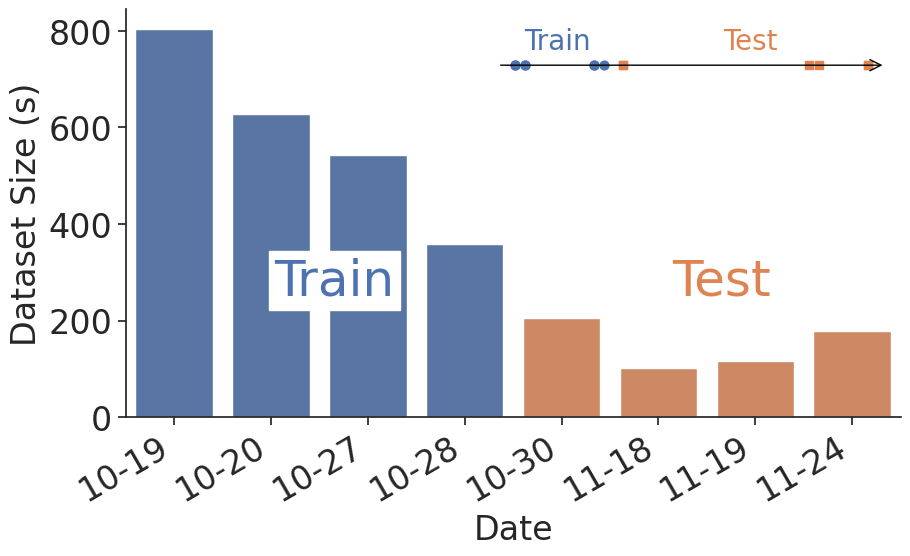

In [3]:
from visualization import plot_split_bars, plot_timeline
BIN_SIZE_S = 0.02
fig, ax = plt.subplots(figsize=(10, 6))

df = pd.DataFrame({'Date_Full': start_dates, 'Dataset Size': volume, 'Split Type': split_type})
# just get month and day
df['Dataset Size (s)'] = df['Dataset Size'] * BIN_SIZE_S
df['Date'] = df['Date_Full'].dt.strftime('%m-%d')

plot_split_bars(df, fig, ax)

sections = df.groupby(
    'Split Type'
)['Date'].apply(list).to_dict()
# sort section by section name, respect Train, Test Short, Test Long order
sections = {k: v for k, v in sorted(sections.items(), key=lambda item: item[1])}

plot_timeline(ax, sections)

# Quick Overview

The dataset provides recorded neural spiking activity and position and velocity kinematic covariates. For visualization, some trial metadata is included. The velocities are the decoding targets

Here we will visualize the experimental data. We will first load the NWB files, bin the spike times, and then plot the binned spikes and finger velocity.

In [4]:
from falcon_challenge.dataloaders import bin_units
BIN_SIZE_S = 0.02

def load_nwb(fn: str):
    print(f'Loading {fn}')
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()

        trial_info = (
            nwbfile.trials.to_dataframe()
            .reset_index()
            .rename({"id": "trial_id", "tgt_pos": "target"}, axis=1)
        )
        vel_container = nwbfile.acquisition['finger_vel']
        labels = [ts for ts in vel_container.time_series]
        vel_data = []
        vel_timestamps = None
        for ts in labels: 
            ts_data = vel_container.get_timeseries(ts)
            vel_data.append(ts_data.data[:])
            vel_timestamps = ts_data.timestamps[:]
        vel_data = np.vstack(vel_data).T

        units = nwbfile.units.to_dataframe()
        print(vel_timestamps)
        print((np.unique(np.diff(vel_timestamps))))
        # print((np.isclose(np.diff(vel_timestamps), 0.02)))
        # breakpoint()
        binned_units = bin_units(units, bin_size_s=BIN_SIZE_S, bin_timestamps=vel_timestamps, is_timestamp_bin_start=True)

        eval_mask = nwbfile.acquisition['eval_mask'].data[:].astype(bool)

        return (
            binned_units,
            vel_data,
            vel_timestamps,
            labels,
            trial_info,
            eval_mask
        )

spikes, vel, time, labels, tinfo, eval_mask = load_nwb(train_files[0])

Loading data/m2/held_in/Z_Joker_2020-10-19_Run-002_calibration.nwb
[0.00000e+00 2.00000e-02 4.00000e-02 ... 3.99137e+02 3.99157e+02
 3.99177e+02]
[0.003 0.003 0.003 0.003 0.004 0.004 0.004 0.004 0.005 0.005 0.006 0.006
 0.006 0.007 0.007 0.007 0.007 0.007 0.008 0.008 0.008 0.008 0.009 0.009
 0.009 0.009 0.01  0.01  0.01  0.01  0.01  0.01  0.011 0.011 0.011 0.011
 0.011 0.011 0.012 0.013 0.013 0.013 0.013 0.013 0.014 0.014 0.014 0.014
 0.015 0.015 0.015 0.015 0.015 0.016 0.016 0.016 0.016 0.016 0.017 0.017
 0.018 0.018 0.018 0.018 0.019 0.019 0.019 0.019 0.019 0.02  0.02  0.02
 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.021
 0.021 0.021 0.021 0.021 0.022 0.022 0.022 0.022 0.022 0.022 1.082]


(20028, 96) (20028, 2) (20028,) ['index', 'mrs']
[  207   180   757  3719   144   267 10495   390   297   195   350   162
   143   111   258   149   179   115   155   150   140   126   111   112
   139   136   151   127   130   142   106   156 14961   170   743    96
   363  5092   160  3086   171   163   328   135   131   153   149   147
   165   163  2811   120   676   113   132   156   156   233   109   183
   177   190   119   153  3243   103  2318  2466  1909    84  9958 29525
 22194  3907  1668  1049   299   634   600   425 10870 12236  1249 19538
   280  1252   341   207    93 17017  3234  3465   582   183   129   178]
[0.00000e+00 2.00000e-02 4.00000e-02 ... 3.99137e+02 3.99157e+02
 3.99177e+02]


<Axes: ylabel='Count'>

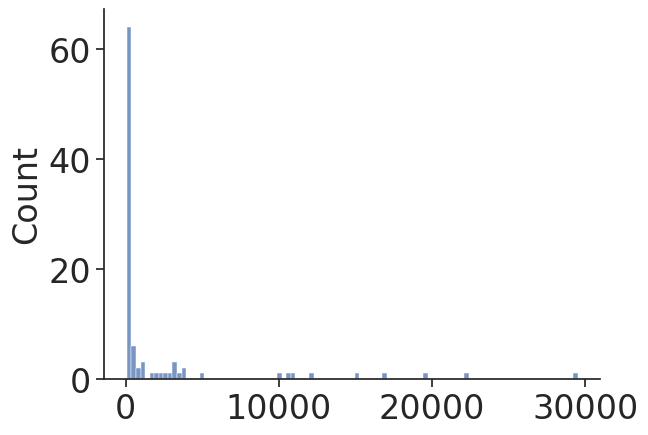

In [5]:
print(spikes.shape, vel.shape, time.shape, labels)
print(spikes.sum(0))
print(time)
sns.histplot(spikes.sum(0))

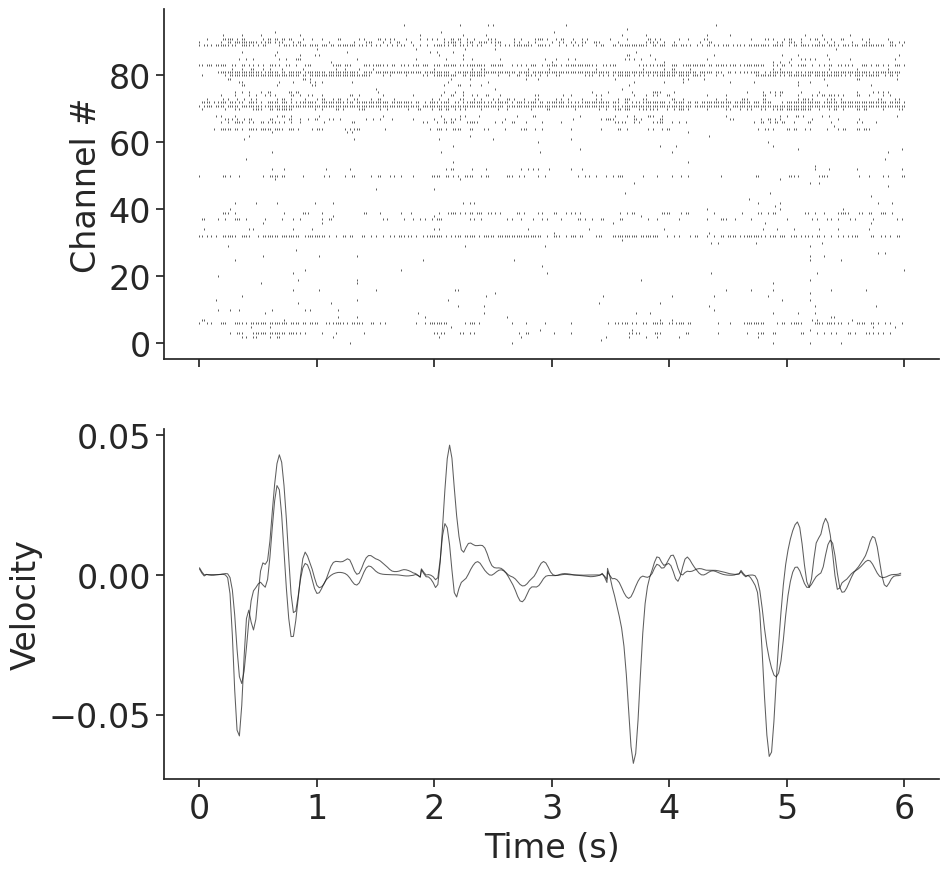

In [6]:
from visualization import rasterplot
VIZ_LIMIT = 301
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=False)
rasterplot(spikes[:VIZ_LIMIT, :], bin_size_s=BIN_SIZE_S, ax=ax[0], spike_alpha=1.0, lw=0.5, s=3)
ax[1].plot(time[:VIZ_LIMIT], vel[:VIZ_LIMIT, :], linewidth=0.75, color='k', alpha=0.7)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Velocity')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.show()

# Neural activity statistics change over time 

The neural activity in these datasets consist of multiunit threshold crossings, putatively attributed to nearby spiking activity.

The statistics of neural activity are stable over the course of a single calibration period, but can be quite unstable over the course of multiple days. We see that simply by plotting the raw neural activity from consecutive days together. Instabilities can for example be attributed by given channels being more or less active on a given day, even though these channels _provide decoding signal_ on that day.

In [7]:
# load each day's data 
binned_neural = {}
tgts = {}
metadata = {}
lengths = {}
times = {}
masks = {}

for f in train_files + test_files: 
    spikes, tgt, time, labels, tinfo, eval_mask = load_nwb(f)
    key = '_'.join(f.stem.split('_')[2:-1])
    binned_neural[key] = spikes
    lengths[key] = spikes.shape[0]
    tgts[key] = tgt 
    metadata[key] = tinfo
    times[key] = time
    masks[key] = eval_mask

Loading data/m2/held_in/Z_Joker_2020-10-19_Run-002_calibration.nwb
[0.00000e+00 2.00000e-02 4.00000e-02 ... 3.99137e+02 3.99157e+02
 3.99177e+02]
[0.003 0.003 0.003 0.003 0.004 0.004 0.004 0.004 0.005 0.005 0.006 0.006
 0.006 0.007 0.007 0.007 0.007 0.007 0.008 0.008 0.008 0.008 0.009 0.009
 0.009 0.009 0.01  0.01  0.01  0.01  0.01  0.01  0.011 0.011 0.011 0.011
 0.011 0.011 0.012 0.013 0.013 0.013 0.013 0.013 0.014 0.014 0.014 0.014
 0.015 0.015 0.015 0.015 0.015 0.016 0.016 0.016 0.016 0.016 0.017 0.017
 0.018 0.018 0.018 0.018 0.019 0.019 0.019 0.019 0.019 0.02  0.02  0.02
 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.021
 0.021 0.021 0.021 0.021 0.022 0.022 0.022 0.022 0.022 0.022 1.082]
Loading data/m2/held_in/Z_Joker_2020-10-19_Run-003_calibration.nwb
[0.00000e+00 2.00000e-02 4.00000e-02 ... 4.01579e+02 4.01599e+02
 4.01619e+02]
[0.003 0.003 0.003 0.003 0.004 0.004 0.004 0.004 0.004 0.005 0.005 0.005
 0.005 0.006 0.006 0.006 0.007 0.007 0.007 0.008 0.008 0.

In [9]:
trim_binned_neural = []
ind_binned_neural = []

for bn in binned_neural:
    trim_binned_neural.append(binned_neural[bn][:4001, :])
    ind_binned_neural.append(binned_neural[bn])

trim_binned_neural = np.vstack(trim_binned_neural)

all_binned_neural = np.vstack(ind_binned_neural)

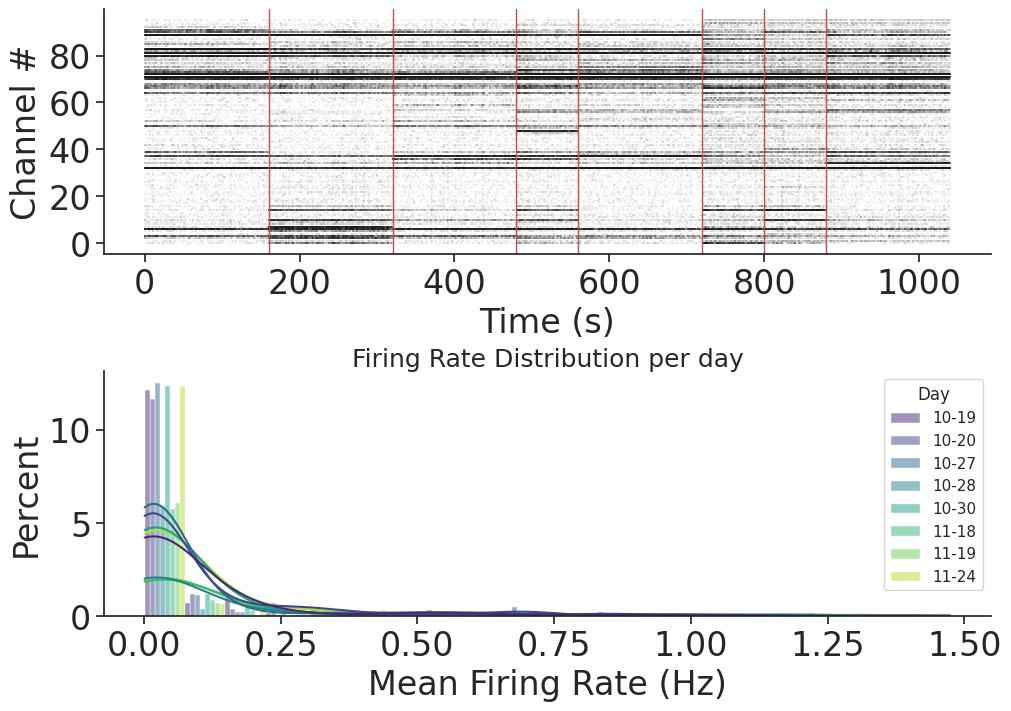

In [10]:
# Plot snippets of multiple days back to back to note change in structure
from visualization import plot_firing_rate_distributions 

f, axes = plt.subplots(2, 1, figsize=(10, 7), layout='constrained')

rasterplot(trim_binned_neural, ax=axes[0])
trim_lengths = [4001 for x in lengths]
day_intervals = np.cumsum(trim_lengths)

for i, length in enumerate(day_intervals[:-1]):
    if start_dates[i] == start_dates[i + 1]:
        continue 
    axes[0].axvline(length * BIN_SIZE_S, color='r', linewidth=1)
axes[0].set_xlabel('Time (s)')

plot_firing_rate_distributions(lengths, all_binned_neural, start_dates, axes[1])

# Training and evaluating a linear decoder 

The FALCON benchmark measures decoding performance from neural data. Here we provide a basic linear decoder baseline, and evaluate this decoder only on the full trial.

Note that we provide multiple days of training data. Decodability of different muscles varies across these days. Current practice prepares linear decoders using data from a single day. Linear decoders may or may not be able to exploit the multiple days of data - feel free to experiment!

In [11]:
# get smoothed spikes 
from preproc.filtering import apply_exponential_filter
smoothed_spikes = {}

for bn in binned_neural:
    smoothed_spikes[bn] = apply_exponential_filter(binned_neural[bn])
print(smoothed_spikes.keys())

dict_keys(['2020-10-19_Run-002', '2020-10-19_Run-003', '2020-10-20_Run-002', '2020-10-20_Run-003', '2020-10-27_Run-002', '2020-10-27_Run-003', '2020-10-28_Run-001', '2020-10-30_Run-001', '2020-10-30_Run-002', '2020-11-18_Run-001', '2020-11-19_Run-001', '2020-11-24_Run-001', '2020-11-24_Run-002'])


In [12]:
train_keys = ['2020-10-19_Run-002', '2020-10-19_Run-003']

# Assuming smoothed_spikes and are 2D arrays with the same number of rows as time
concat_eval_mask = np.array(np.hstack([masks[k] for k in train_keys]))
concat_tgt = np.concatenate([tgts[k] for k in train_keys])
concat_spikes = np.concatenate([smoothed_spikes[k] for k in train_keys])
concat_times = np.concatenate([times[k] for k in train_keys])

tgt_trials = concat_tgt[concat_eval_mask]
smoothed_spikes_trials = concat_spikes[concat_eval_mask]
trial_times = concat_times[concat_eval_mask]
print(len(tgt_trials))


40228


In [13]:
from decoder_demos.decoding_utils import (
    zscore_data,
    generate_lagged_matrix,
    apply_neural_behavioral_lag,
    fit_and_eval_decoder
)

# split into train and valid 
split_ind = int(0.8 * len(tgt_trials))

smoothed_spikes_train, smoothed_spikes_valid = np.split(smoothed_spikes_trials, [split_ind])
tgt_train, tgt_valid = np.split(tgt_trials, [split_ind])
time_train, time_valid = np.split(trial_times, [split_ind])

# train a decoder 
valid_score, decoder, y_pred = fit_and_eval_decoder(
    zscore_data(smoothed_spikes_train),
    tgt_train,
    zscore_data(smoothed_spikes_valid),
    tgt_valid,
    return_preds=True
)

# Print the score
print('Validation score:', valid_score) 

Validation score: 0.2442572075453528


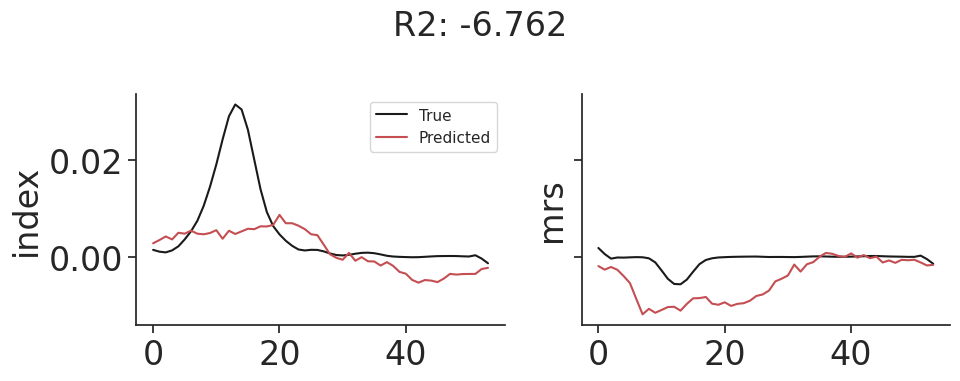

In [14]:
# plot an example trial from the validation data 
from sklearn.metrics import r2_score

time_train, time_valid = np.split(trial_times, [split_ind])
start_ind = np.searchsorted(time_valid, metadata[train_keys[-1]]['start_time'].iloc[-1])
end_ind = np.searchsorted(time_valid, metadata[train_keys[-1]]['stop_time'].iloc[-1])
tgt_trial = tgt_valid[start_ind:end_ind, :]
pred_trial = y_pred[start_ind:end_ind, :]

num_dims = tgt_trials.shape[1]

# Create a grid of subplots with num_dims rows and 1 column
fig, ax = plt.subplots(num_dims//2, 2, figsize=(10, 4), sharex=True, sharey=True)
axs = ax.flatten()

# Loop through each dimension
for i in range(num_dims):
    # Get the true and predicted data for the trial and dimension
    true_data = tgt_trial[:, i]
    predicted_data = pred_trial[:, i]

    # Plot the data in the subplot
    axs[i].plot(true_data, label='True', color='k')
    axs[i].plot(predicted_data, label='Predicted', color='r')
    axs[i].set_ylabel(labels[i])
    if i == 0:
        axs[i].legend()

plt.suptitle(f'R2: {np.around(r2_score(tgt_trial, pred_trial), 3)}')
plt.tight_layout()
plt.show()

# Variations on a linear decoder

In motor tasks it is common to either incorporate historical data into the neural features (e.g., a Wiener Filter) or impose a lag on the neural data with respect to the behavior. Here we will demonstrate how those properties affect this dataset and how you may consider applying these utilities in your own methods.

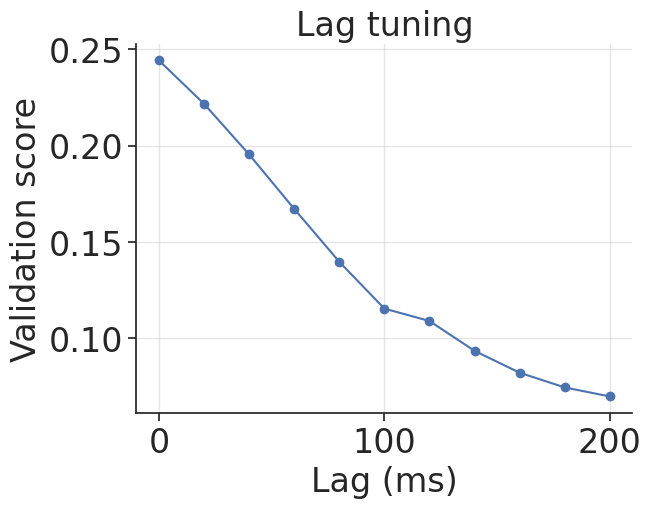

In [15]:
# checking if neural-behavioral lag improves decoding performance 

lag_ms = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
lag_scores = []

for lm in lag_ms: 
    lag_bins = int(lm / 20)
    lag_neural_train, lag_behavior_train = apply_neural_behavioral_lag(
        zscore_data(smoothed_spikes_train),
        tgt_train,
        lag_bins
    )
    lag_neural_valid, lag_behavior_valid = apply_neural_behavioral_lag(
        zscore_data(smoothed_spikes_valid),
        tgt_valid,
        lag_bins
    )
    valid_score, _ = fit_and_eval_decoder(
        lag_neural_train,
        lag_behavior_train,
        lag_neural_valid,
        lag_behavior_valid,
        return_preds=False
    )
    lag_scores.append(valid_score)

plt.figure()
plt.plot(lag_ms, lag_scores, marker='o')
plt.xlabel('Lag (ms)')
plt.ylabel('Validation score')
plt.title('Lag tuning')
plt.grid(alpha=0.5)

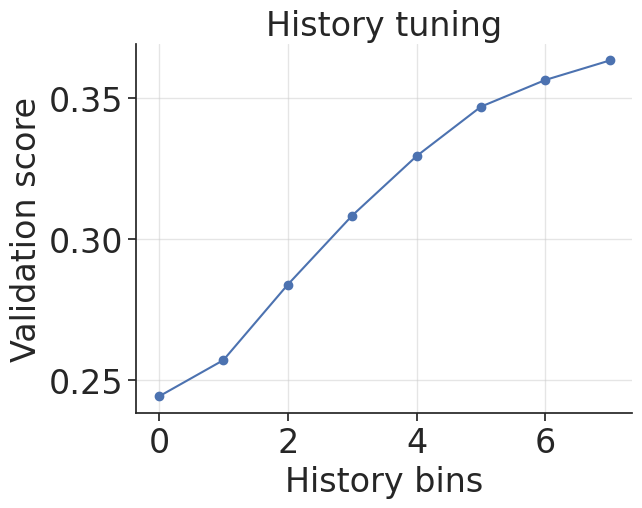

In [16]:
history_bins = [0, 1, 2, 3, 4, 5, 6, 7]
history_scores = []

for hb in history_bins: 
    if hb > 0: 
        train_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_train), hb)
        valid_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_valid), hb)
        train_behavioral = tgt_train[hb:]
        valid_behavioral = tgt_valid[hb:]
    else:
        train_neural = zscore_data(smoothed_spikes_train)
        valid_neural = zscore_data(smoothed_spikes_valid)
        train_behavioral = tgt_train
        valid_behavioral = tgt_valid
    valid_score, _ = fit_and_eval_decoder(
        train_neural,
        train_behavioral,
        valid_neural,
        valid_behavioral,
        return_preds=False
    )
    history_scores.append(valid_score)

plt.figure()
plt.plot(history_bins, history_scores, marker='o')
plt.xlabel('History bins')
plt.ylabel('Validation score')
plt.title('History tuning')
plt.grid(alpha=0.5)

In [17]:
# move forward with best decoder 

n_lag = 0
n_hist = 7

train_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_train), n_hist)
valid_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_valid), n_hist)
train_behavioral = tgt_train[hb:]
valid_behavioral = tgt_valid[hb:]

valid_score, decoder = fit_and_eval_decoder(
    train_neural,
    train_behavioral,
    valid_neural,
    valid_behavioral,
    return_preds=False
)


# Multi-day decoding 
FALCON evaluates decoder performance on novel days. Current decoders, including the simple linear decoder we train here, have greatly reduced performance when applied naively to new days. This issue is also a deeper change than surface level firing rate shifts. Real world performance thus requires advances in multi-day transfer, whether this comes from better base models, better calibration methods, or better test-time adaptation.

In [18]:
test_keys = [
    '2020-10-30_Run-001', 
    '2020-10-30_Run-002',
    '2020-11-18_Run-001',
    '2020-11-19_Run-001',
    '2020-11-24_Run-001',
    '2020-11-24_Run-002',
]

performance = [valid_score]
for k in test_keys:
    smoothed_spikes_trials = generate_lagged_matrix(zscore_data(smoothed_spikes[k][masks[k]]), n_hist)
    tgt_trials = tgts[k][masks[k]][n_hist:]

    # Use the decoder to predict an output
    y_pred = decoder.predict(smoothed_spikes_trials)

    score = r2_score(tgt_trials, y_pred, multioutput='variance_weighted')
    performance.append(score)
    
    # Print the average score
    print(f'{k} R^2:', score)

2020-10-30_Run-001 R^2: 0.14330959881644678
2020-10-30_Run-002 R^2: 0.1353628545475637
2020-11-18_Run-001 R^2: 0.1114990038974813
2020-11-19_Run-001 R^2: 0.028868736583848465
2020-11-24_Run-001 R^2: 0.16854145642678137
2020-11-24_Run-002 R^2: 0.04212739558999819


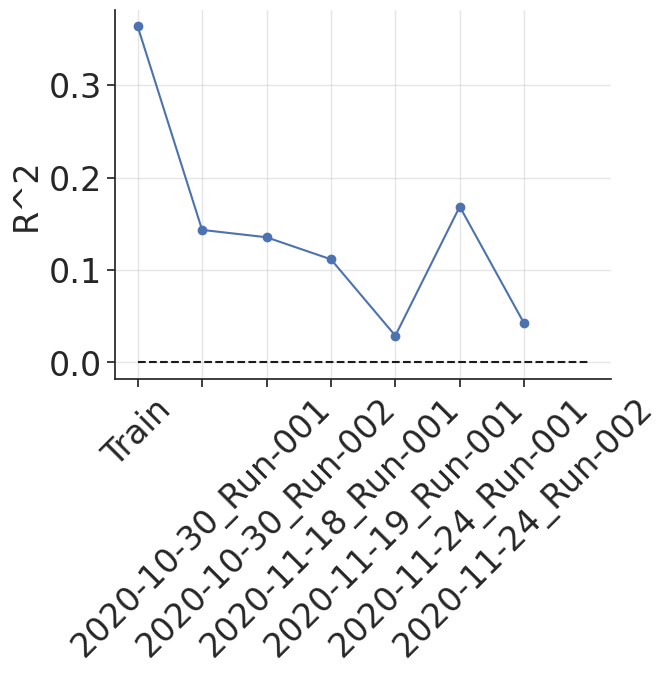

In [19]:
plt.figure()
plt.plot(performance, marker='o')
plt.xticks(range(1 + len(test_keys)), ['Train'] + test_keys, rotation=45)
plt.hlines(0, 0, 1 + len(test_keys), linestyles='dashed', color='k')
plt.ylabel('R^2')
plt.grid(alpha=0.5)